In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

import warnings

warnings.filterwarnings('ignore')
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('max_colwidth', 200)

## 数据集压缩

In [2]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    """

    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

# 剔除异常值

In [3]:
# 剔除EDA发现的异常值
def drop_incorrect(df):
    df = df[df['campaign'] <= 24]
    df = df[df['previous'] <= 24]
    df = df[df['pdays'] <= 400]
    return df

# 缺失值处理

In [4]:

'''
unknown值填充
Percentage of "unknown" in job： 288 / 45211
Percentage of "unknown" in education： 1857 / 45211
Percentage of "unknown" in contact： 13020 / 45211
Percentage of "unknown" in poutcome： 36959 / 45211
'''
def fill_unknown(df, ues_rf_interpolation=True, use_knn_interpolation=False):
    fill_attrs = ['job', 'education', 'contact', 'poutcome']
    # 出现次数少于5%的字段直接删除
    for i in reversed(fill_attrs):
        if df[df[i] == 'unknown']['y'].count() / len(df) < 0.05:
            df = df[df[i] != 'unknown']
            fill_attrs.remove(i)

    # 出现次数少于30%的可以用随机森林插值或者最近邻插值
    if ues_rf_interpolation:
        for i in fill_attrs:
            if df[df[i] == 'unknown']['y'].count() / len(df) < 0.3:
                df = rf_interpolation(df, i)
                fill_attrs.remove(i)

    if use_knn_interpolation:
        for i in fill_attrs:
            if df[df[i] == 'unknown']['y'].count() / len(df) < 0.3:
                df = knn_interpolation(df, i)
                fill_attrs.remove(i)

    # 出现次数大于25%的保留并视做一类新的类别
    print("remain unknown feature: ", fill_attrs)

    return df


def rf_interpolation(df, i):
    tmp = df.copy()
    data = encoding(tmp)

    test_data = data[data[i] == 'unknown']
    test_data.drop(i, inplace=True)
    train_data = data[data[i] != 'unknown']
    trainY = train_data.pop(i)

    test_data[i] = train_rf(train_data, trainY, test_data)
    data = pd.concat([train_data, test_data])

    return data


def knn_interpolation(df, i):
    tmp = df.copy()
    data = encoding(tmp)

    test_data = data[data[i] == 'unknown']
    test_data.drop(i, inplace=True)
    train_data = data[data[i] != 'unknown']
    trainY = train_data.pop(i)

    test_data[i] = train_knn(train_data, trainY, test_data)
    data = pd.concat([train_data, test_data])

    return data


def train_rf(trainX, trainY, testX):
    forest = RandomForestClassifier(n_estimators=100)
    forest = forest.fit(trainX, trainY)
    test_predictY = forest.predict(testX).astype(int)
    return pd.DataFrame(test_predictY, index=testX.index)


def train_knn(trainX, trainY, testX):
    knn = KNeighborsClassifier()
    knn = knn.fit(trainX, trainY)
    test_predictY = knn.predict(testX).astype(int)
    return pd.DataFrame(test_predictY, index=testX.index)


# 构造特征

In [5]:
def q80(x):
    return x.quantile(0.8)


def q30(x):
    return x.quantile(0.3)


def feature_engineering(df):
    # 年龄分箱
    df['age_buckets'] = pd.qcut(df['age'], 20, labels=False, duplicates='drop')
    age = df[['age_buckets', 'balance']]
    age = age.groupby(['age_buckets']).agg({'balance': ['mean']}).reset_index()
    age.columns = ['age_buckets', 'age_mean']
    df = pd.merge(df, age, on=['age_buckets'], how='left')

    # 与同龄人balance均值的差值
    df['age_balance'] = df['balance'] - df['age_mean']

    # 贷款、房贷与违约的联合特征
    loan = df[['default', 'housing', 'loan', 'balance']]
    loan = loan.groupby(['default', 'housing', 'loan']).agg({'balance': ['min', 'max', 'mean', 'std', 'skew', 'median',
                                                                         q80, q30, pd.DataFrame.kurt, 'mad',
                                                                         np.ptp]}).reset_index()
    loan.columns = ['default', 'housing', 'loan', 'loan_min', 'loan_max', 'loan_mean', 'loan_std', 'loan_skew',
                    'loan_median', 'loan_q80', 'loan_q30', 'loan_kurt', 'loan_mad', 'loan_ptp']
    df = pd.merge(df, loan, on=['default', 'housing', 'loan'], how='left')

    # 职业与余额的联合特征
    job = df[['job', 'balance']]
    job = job.groupby(['job']).agg({'balance': ['min', 'max', 'mean', 'std', 'skew', 'median', q80,
                                                q30, pd.DataFrame.kurt, 'mad', np.ptp]}).reset_index()
    job.columns = ['job', 'job_min', 'job_max', 'job_mean', 'job_std', 'job_skew',
                   'job_median', 'job_q80', 'job_q30', 'job_kurt', 'job_mad', 'job_ptp']
    df = pd.merge(df, job, on=['job'], how='left')

    # 与同龄人balance均值的差值
    df['job_balance'] = df['balance'] - df['job_mean']

    # 婚姻、教育水平与余额的联合特征
    tmp = df[['marital', 'education', 'balance']]
    tmp = tmp.groupby(['marital', 'education']).agg({'balance': ['min', 'max', 'mean', 'std', 'skew', 'median', q80,
                                                                 q30, pd.DataFrame.kurt, 'mad', np.ptp]}).reset_index()
    tmp.columns = ['marital', 'education', 'balance_min', 'balance_max', 'balance_mean', 'balance_std', 'balance_skew',
                   'balance_median', 'balance_q80', 'balance_q30', 'balance_kurt', 'balance_mad', 'balance_ptp']
    df = pd.merge(df, tmp, on=['marital', 'education'], how='left')

    print("after feature engineering:", df.shape)

    return df

# Encoding

In [6]:
# 编码：yes == 1, no == 0
def get_dummy_from_bool(row, column_name):
    return 1 if row[column_name] == 'yes' else 0


def encoding(df):
    sparse_features = train.select_dtypes(include='object').columns.tolist()
    dense_features = train.select_dtypes(include='int').columns.tolist()
    sparse_features.remove('y')
    print(len(sparse_features), sparse_features)
    print(len(dense_features), dense_features)

    # 将yes与no的进行编码
    bool_columns = ['default', 'housing', 'loan', 'y']
    for bool_col in bool_columns:
        df[bool_col] = df.apply(lambda row: get_dummy_from_bool(row, bool_col), axis=1)

    # 对类别特征独热编码
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    for col in cat_columns:
        df = pd.concat(
            [df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',
                                                  drop_first=True, dummy_na=False)], axis=1)
    # 数值型特征归一化
    scaler = StandardScaler()
    df[dense_features] = scaler.fit_transform(df[dense_features])

    return df

# Pipeline

In [7]:
def data_preprocess(df):
    df = drop_incorrect(df)
    df = fill_unknown(df, ues_rf_interpolation=False)
    df = feature_engineering(df)
    print(df.shape)
    df = encoding(df)

    return df

In [8]:
PATH = "data/"
train = pd.read_csv(PATH + 'bank-full.csv', sep=';')
print(train.shape)
train = data_preprocess(train)
print(train.shape)
train.head(5)

(45211, 17)
remain unknown feature:  ['contact', 'poutcome']
after feature engineering: (42808, 54)
(42808, 54)
9 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
7 ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
(42808, 78)


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y,age_buckets,age_mean,age_balance,loan_min,loan_max,loan_mean,loan_std,loan_skew,loan_median,loan_q80,loan_q30,loan_kurt,loan_mad,loan_ptp,job_min,job_max,job_mean,job_std,job_skew,job_median,job_q80,job_q30,job_kurt,job_mad,job_ptp,job_balance,balance_min,balance_max,balance_mean,balance_std,balance_skew,balance_median,balance_q80,balance_q30,balance_kurt,balance_mad,balance_ptp,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.637923,0,0.261192,1,0,-1.300837,0.008319,-0.638551,-0.414489,-0.321716,0,18,1933.050879,209.949121,-4057,58544,1273.646053,2573.236245,5.669619,456.0,1735.0,153.0,58.196414,1420.791472,62601,-6847,102127,1757.715102,3834.709523,7.862770,565.0,2420.4,164.2,127.330336,1992.479380,108974,385.284898,-6847,98417,1842.217886,3921.923988,6.588844,594.5,2551.4,178.0,83.986280,2072.021161,105264,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.306550,0,-0.436097,1,0,-1.300837,-0.417520,-0.638551,-0.414489,-0.321716,0,12,1411.291897,-1382.291897,-4057,58544,1273.646053,2573.236245,5.669619,456.0,1735.0,153.0,58.196414,1420.791472,62601,-2827,34646,1234.466255,2488.066902,4.881318,415.0,1740.0,118.0,36.795304,1413.336092,37473,-1205.466255,-8019,56831,1058.177642,2291.876494,6.614781,352.0,1408.0,114.7,85.420131,1214.304619,64850,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,-0.739530,0,-0.445003,1,1,-1.300837,-0.707866,-0.638551,-0.414489,-0.321716,0,4,1227.999492,-1225.999492,-3058,34230,823.374818,1870.821507,5.975102,292.0,1224.0,44.0,63.027436,1018.323527,37288,-2082,59649,1522.880257,4176.526249,7.615291,352.0,1843.0,93.0,77.501341,1861.178442,61731,-1520.880257,-2082,81204,1252.943400,2764.266527,8.873518,435.0,1745.4,123.0,164.379797,1419.467793,83286,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,-0.549333,0,-0.369469,1,0,-1.300837,-0.463976,-0.638551,-0.414489,-0.321716,0,6,1108.287921,-877.287921,-4057,58544,1273.646053,2573.236245,5.669619,456.0,1735.0,153.0,58.196414,1420.791472,62601,-6847,102127,1757.715102,3834.709523,7.862770,565.0,2420.4,164.2,127.330336,1992.479380,108974,-1526.715102,-6847,98417,1842.217886,3921.923988,6.588844,594.5,2551.4,178.0,83.986280,2072.021161,105264,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,-1.215020,0,-0.298223,1,1,-1.300837,-0.162017,-0.638551,-0.414489,-0.321716,0,1,981.168539,-534.168539,-3058,34230,823.374818,1870.821507,5.975102,292.0,1224.0,44.0,63.027436,1018.323527,37288,-6847,102127,1757.715102,3834.709523,7.862770,565.0,2420.4,164.2,127.330336,1992.479380,108974,-1310.715102,-1980,102127,1629.167056,3502.892011,9.328277,591.0,2206.0,206.0,181.730033,1772.647573,104107,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


# feature selection

In [9]:

def variance_filter(data):
    X = data.drop(columns='y', inplace=False)
    filter = VarianceThreshold(threshold=0.01)
    mask = filter.fit(X)._get_support_mask()
    origin_columns = X.columns.values
    drop_columns = origin_columns[mask == False]
    print("variance_filter del feature: ", drop_columns)
    data.drop(drop_columns, axis=1, inplace=True)
    print(data.shape)

    return data

train = variance_filter(train)

variance_filter del feature:  ['month_dec']
(42808, 77)


In [10]:
def mutual_info_classif_filter(data, plot=False):
    train = data.copy()
    y = train.pop('y')
    xbest = SelectKBest(mutual_info_classif, k='all').fit(train, y)

    scores = pd.DataFrame(xbest.scores_)
    columns = pd.DataFrame(data.columns)
    colscores = pd.concat([columns, scores], axis=1)
    colscores.columns = ['col', 'score']
    if plot:
        print(colscores.sort_values(by='score', axis=0, ascending=False))
    # filter = colscores[colscores['score'] > 0]['col'].values
    drop_columns = colscores[colscores['score'] <= 0]['col'].values
    print("mutual_info_classif_filter del feature: ", drop_columns)
    data.drop(drop_columns, axis=1, inplace=True)
    print(data.shape)
    return data

train = mutual_info_classif_filter(train)

mutual_info_classif_filter del feature:  ['default' 'job_blue-collar' 'job_entrepreneur' 'month_feb' 'month_sep']
(42808, 72)


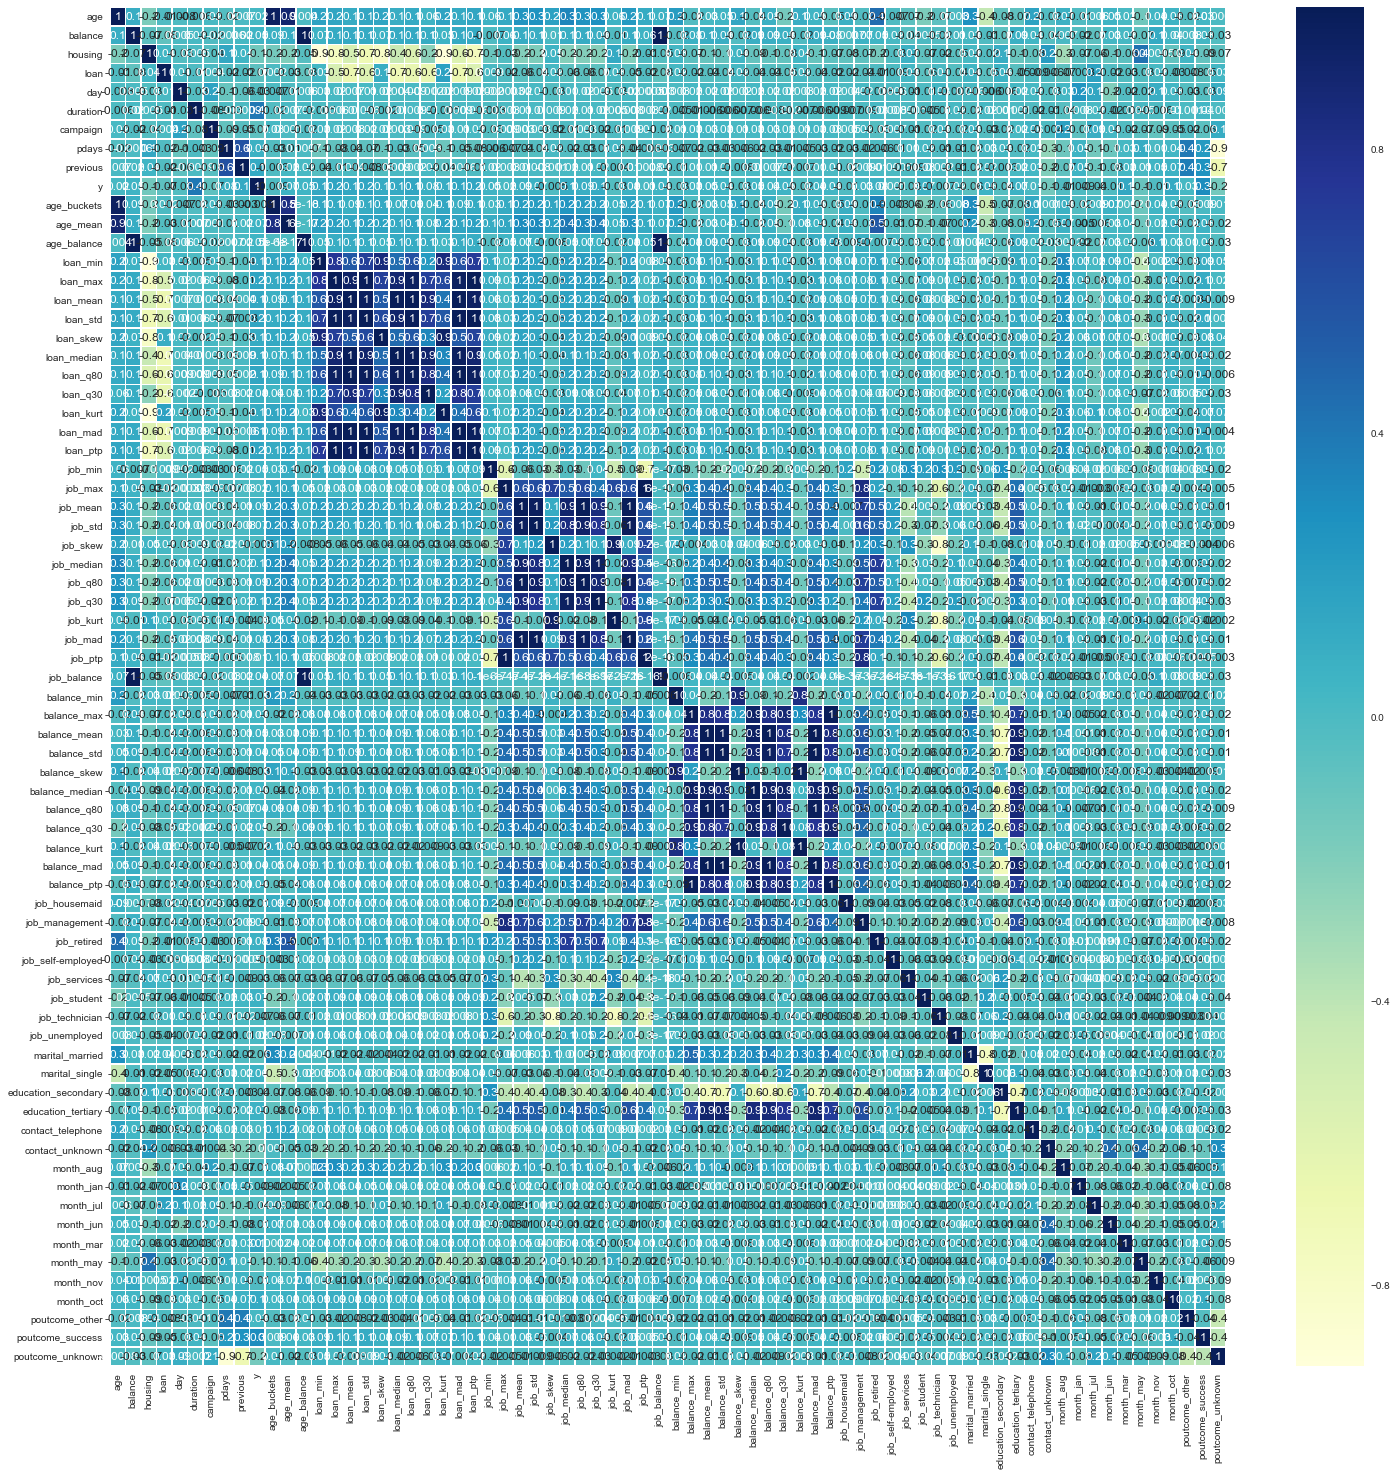

corr_filter del feature:  ['loan_q80' 'loan_mad' 'loan_ptp' 'job_ptp']
(42808, 68)


In [11]:
def corr_filter(data, plot=False):
    sns.set(rc={'figure.figsize': (25, 25)})
    corr = data.corr()
    if plot:
        plt.figure()
        ax = sns.heatmap(corr, linewidths=.5, annot=True, cmap="YlGnBu", fmt='.1g')
        plt.show()

    # Drop highly correlated features
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= 0.995:
                if columns[j]:
                    columns[j] = False
    # feature_columns = data.columns[columns == True].values
    drop_columns = data.columns[columns == False].values
    data.drop(drop_columns, axis=1, inplace=True)
    print("corr_filter del feature: ", drop_columns)
    print(data.shape)
    return data

train = corr_filter(train, plot=True)

# Save data

In [12]:
path = 'process_data/process_data.csv'
train.to_csv(path, index=False)

# 一些启发

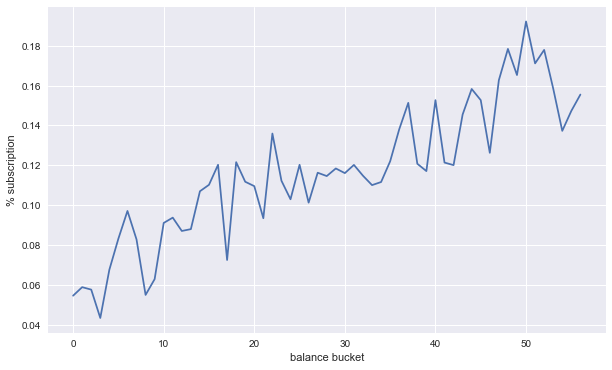

In [35]:
df_new = train.copy()
df_new['balance_buckets'] = pd.qcut(df_new['balance'], 60, labels=False, duplicates='drop')

mean_deposit = df_new.groupby(['balance_buckets'])['y'].mean()

# 
plt.figure(figsize=[10,6])
plt.plot(mean_deposit.index, mean_deposit.values)
plt.xlabel('balance bucket')
plt.ylabel('% subscription')
plt.show()

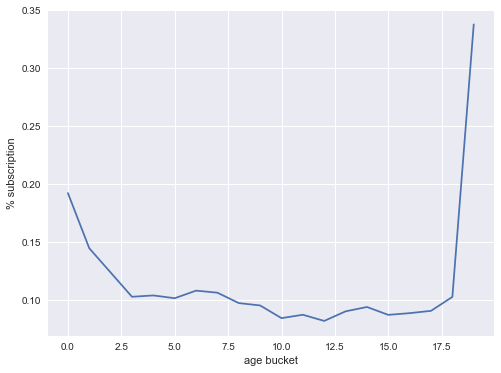

In [28]:
df_new = train.copy()
df_new['age_buckets'] = pd.qcut(df_new['age'], 20, labels=False, duplicates='drop')
mean_deposit = df_new.groupby(['age_buckets'])['y'].mean()

# 
plt.figure(figsize=[8,6])
plt.plot(mean_deposit.index, mean_deposit.values)
plt.xlabel('age bucket')
plt.ylabel('% subscription')
plt.show()

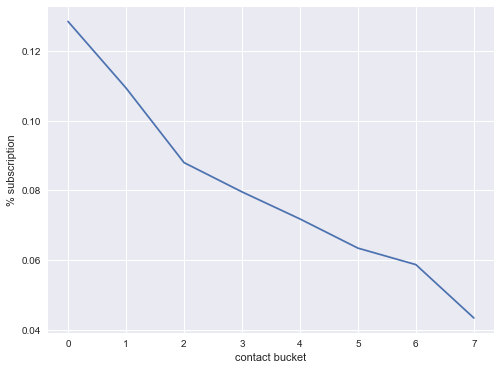

In [38]:
df_new = train.copy()
df_new['campaign_buckets'] = pd.qcut(df_new['campaign'], 40, labels=False, duplicates='drop')

mean_deposit = df_new.groupby(['campaign_buckets'])['y'].mean()

plt.figure(figsize=[8,6])
plt.plot(mean_deposit.index, mean_deposit.values)
plt.xlabel('contact bucket')
plt.ylabel('% subscription')
plt.show()